In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import os

from DiffusionFreeGuidence.DiffusionCondition import GaussianDiffusionSampler, GaussianDiffusionTrainer
from DiffusionFreeGuidence.ModelCondition import UNet
from Utils import get_pointwise_mutual_info_2, get_pointwise_mutual_info_3, get_intermediate_pointwise_mutual_info

def visualize_single_image(image_tensor):
    if image_tensor.shape != (3, 32, 32):
        raise ValueError("Invalid shape")
    image_tensor = (image_tensor + 1) / 2.0
    image_array = image_tensor.numpy().transpose((1, 2, 0))
    plt.imshow(image_array)
    plt.axis('off')
    plt.show()

def visualize_100_images(image_tensor):
    if len(image_tensor) != 100 or image_tensor.shape[1:] != (3, 32, 32):
        raise ValueError("Invalid shape")
        
    fig, axes = plt.subplots(10, 10, figsize=(15, 15),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))

    for i, ax in enumerate(axes.flat):
        img = image_tensor[i].numpy().transpose((1, 2, 0))
        img = (img + 1) / 2.0  # Assuming image was in [-1, 1], scale it back to [0, 1]
        ax.imshow(img)

    plt.show()

def visualize_100_images_with_est(image_tensor, num_array):
    if len(image_tensor) != 100 or image_tensor.shape[1:] != (3, 32, 32) or len(num_array) != 100:
        raise ValueError("Invalid shape")
        
    fig, axes = plt.subplots(10, 10, figsize=(15, 18),  # Adjust figure size
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.4, wspace=0.1))

    for i, ax in enumerate(axes.flat):
        img = image_tensor[i].numpy().transpose((1, 2, 0))
        img = (img + 1) / 2.0  # Assuming image was in [-1, 1], scale it back to [0, 1]
        ax.imshow(img)
        ax.text(0.5, -0.2, str(round(num_array[i], 2)), size=12, ha="center", transform=ax.transAxes)
        
    plt.show()

def generate_and_classify_misgenerated_images(modelConfig, label, num_misgenerated_required):
    misgenerated_images = []
    count = 0

    device = torch.device(modelConfig["device"])
    
    with torch.no_grad():
        model = UNet(T=modelConfig["T"], num_labels=10, ch=modelConfig["channel"], ch_mult=modelConfig["channel_mult"],
                        num_res_blocks=modelConfig["num_res_blocks"], dropout=modelConfig["dropout"]).to(device)
        ckpt = torch.load(os.path.join(modelConfig["save_dir"], modelConfig["test_load_weight"]), map_location=device)
        model.load_state_dict(ckpt)
        model.eval()

        classifier = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_repvgg_a2", pretrained=True)
        classifier = classifier.to(modelConfig["device"])
        classifier.eval()

        sampler = GaussianDiffusionSampler(
            model, modelConfig["beta_1"], modelConfig["beta_T"], modelConfig["T"], w=modelConfig["w"]).to(device)

        while count < num_misgenerated_required:
            noisyImage = torch.randn(
                size=[modelConfig["batch_size"], 3, modelConfig["img_size"], modelConfig["img_size"]], device=device)
            sampledImgs = sampler(noisyImage, torch.tensor([label]*modelConfig["batch_size"]).to(device))

            output = classifier(sampledImgs)
            _, predicted = torch.max(output.data, 1)
            predicted_labels = predicted + 1

            indices_not_equal = torch.nonzero(predicted_labels != label).squeeze()
            if len(indices_not_equal) > 0:
                misgenerated_images.extend(sampledImgs[indices_not_equal])
                count += len(indices_not_equal)

    # Save the misgenerated images
    torch.save(misgenerated_images, f"misgenerated_images_label_{label}_4000steps.pt") # remove

    return misgenerated_images

def get_est(Img, label, model_num, t, iter=5):
    result = 0
    for _ in range(iter):
        _, est = get_intermediate_pointwise_mutual_info(Img, label, model_num, t)
        result += est
    return result/iter

modelConfig = {
    "state": "eval",
    "epoch": 1,
    "batch_size": 100,
    "T": 4000, # 4000
    "channel": 128,
    "channel_mult": [1, 2, 2, 2],
    "num_res_blocks": 2,
    "dropout": 0.15,
    "lr": 1e-4,
    "multiplier": 2.5,
    "beta_1": 1e-4,
    "beta_T": 0.028,
    "img_size": 32,
    "grad_clip": 1.,
    "device": "cuda:0",
    "w": 1.0,
    "save_dir": "./CheckpointsCondition4000/Model_0/", # 4000
    "training_load_weight": None,
    "test_load_weight": "ckpt_99_.pt", # 99
    "sampled_dir": "./SampledImgs/",
    "sampledNoisyImgName": "NoisyGuidenceImgs.png",
    "sampledImgName": "SampledGuidenceImgs.png",
    "nrow": 8
}

In [3]:
# Generate 100 images of dog
label = 4

device = torch.device(modelConfig["device"])
# load model and evaluate
with torch.no_grad():
    model = UNet(T=modelConfig["T"], num_labels=10, ch=modelConfig["channel"], ch_mult=modelConfig["channel_mult"],
                    num_res_blocks=modelConfig["num_res_blocks"], dropout=modelConfig["dropout"]).to(device)
    ckpt = torch.load(os.path.join(
        modelConfig["save_dir"], modelConfig["test_load_weight"]), map_location=device)
    model.load_state_dict(ckpt)
    print("model load weight done.")
    model.eval()
    sampler = GaussianDiffusionSampler(
        model, modelConfig["beta_1"], modelConfig["beta_T"], modelConfig["T"], w=modelConfig["w"]).to(device)
    # Sampled from standard normal distribution
    noisyImage = torch.randn(
        size=[modelConfig["batch_size"], 3, modelConfig["img_size"], modelConfig["img_size"]], device=device)
    sampledImgs, x_hat_tensor, x_t_tensor, snr, alphas_bar = sampler(noisyImage, torch.tensor([label]*modelConfig["batch_size"]).to(device), tracking_mode=True)

model load weight done.


OutOfMemoryError: CUDA out of memory. Tried to allocate 4.58 GiB. GPU 0 has a total capacty of 23.68 GiB of which 1.62 GiB is free. Process 51972 has 21.31 GiB memory in use. Including non-PyTorch memory, this process has 636.00 MiB memory in use. Of the allocated memory 373.92 MiB is allocated by PyTorch, and 6.08 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [2]:
# For concat PMI for every label

est_table = []

for label in range(1, 11):
    est_list_list = torch.load('PMI_along_generation_label_'+str(label)+'_model_0.pt').cpu().numpy()
    est_table.append(est_list_list)

In [5]:
timestep = np.linspace(4000-250,0,4000//250)

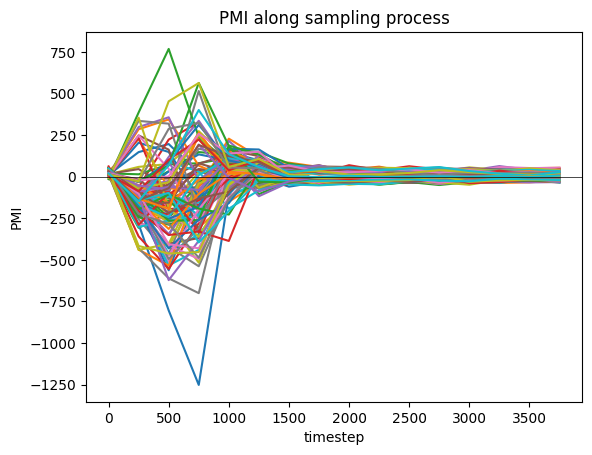

In [11]:
for label in range(10):    
    for i in range(10):
        plt.plot(timestep, est_table[label][i])
plt.xlabel('timestep')
plt.ylabel('PMI')
plt.axhline(0, color='black', linewidth=0.5)
plt.title('PMI along sampling process')

# Display the plot
plt.show()

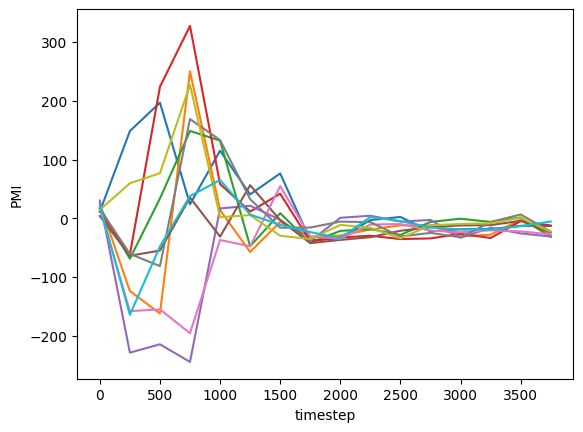

In [20]:
for i in range(10):
    plt.plot(timestep, est_list_list[i])
plt.xlabel('timestep')
plt.ylabel('PMI')

# Display the plot
plt.show()

In [23]:
sampledImgs = torch.load('100_sampled_images_label_'+str(label)+'_model_0.pt')
x_t_tensor = torch.load('100_generation_steps_label_'+str(label)+'_model_0.pt')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


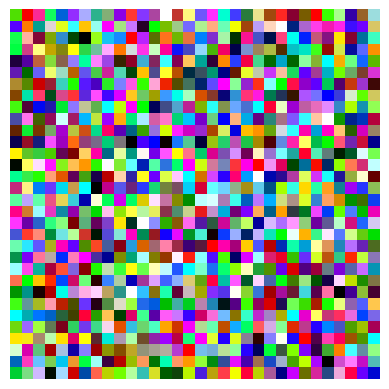

In [27]:
visualize_single_image(x_t_tensor[1][3999].cpu())

In [24]:
print(x_t_tensor.size())

torch.Size([100, 4000, 3, 32, 32])


In [5]:
# For each image, calculate PMI and save indices for negative PMIs
label = 4
indices = []
for i in range(100):
    print(i)
    if get_est(sampledImgs[i], label, 0, t=0, iter=1) < 0:
        indices.append(i)

0


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [6]:
print(indices)

[5, 6, 10, 16, 19, 20, 22, 29, 34, 43, 45, 46, 52, 58, 59, 63, 66, 67, 68, 71, 72, 76, 79, 80, 88, 89, 90, 94]


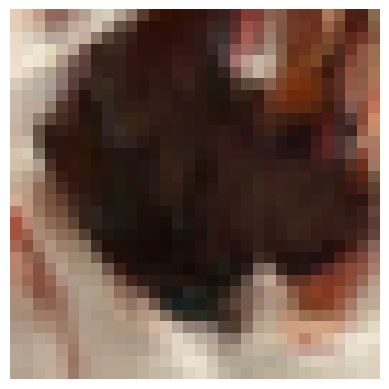

In [12]:
visualize_single_image(sampledImgs[5].cpu())

In [9]:
Img = sampledImgs[0]

In [10]:
diff = Img - x_t_tensor[0][0]

In [13]:
print("t = 4000")
visualize_single_image(x_t_tensor[0][4000-1].cpu())

for i in list(range(1, 4))[::-1]:
    print("t =", i*1000)
    visualize_single_image(x_t_tensor[0][i*1000-1].cpu())
    est = get_est(Img, label, model_num=0, t=i*1000, iter=5).cpu().numpy()
    print("PMI =", est)
    print("\n")

print("t = 0")
visualize_single_image(Img.cpu())
est = get_est(Img, label, model_num=0, t=0, iter=5).cpu().numpy()
print("PMI =", est)

t = 4000


NameError: name 'x_t_tensor' is not defined

In [5]:
print(x_t_tensor.size())

torch.Size([1, 4000, 3, 32, 32])


In [3]:
Img = sampledImgs[0]

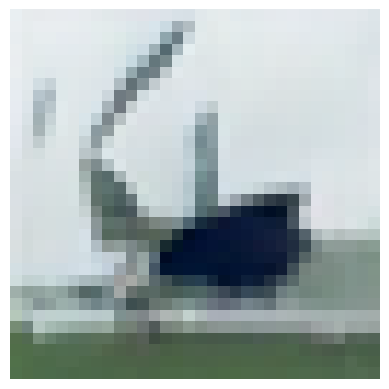

In [4]:
visualize_single_image(Img.cpu())

In [33]:
import importlib
import Utils
importlib.reload(Utils)
from Utils import get_pointwise_mutual_info_2, get_pointwise_mutual_info_3, get_intermediate_pointwise_mutual_info

In [46]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [49]:
_, est = get_intermediate_pointwise_mutual_info(Img, 1, 1, 1000)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [39]:
for label in range(1, 2):
    print(f"Finding misgenerated images for label {label}")
    generate_and_classify_misgenerated_images(modelConfig, label, 10)

Finding misgenerated images for label 2


Using cache found in /home/jovyan/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Finding misgenerated images for label 3


Using cache found in /home/jovyan/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Finding misgenerated images for label 4


Using cache found in /home/jovyan/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Finding misgenerated images for label 5


Using cache found in /home/jovyan/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


TypeError: len() of a 0-d tensor

In [41]:
for label in range(1, 6):
    est_list = []
    misgenerated_images = torch.stack(torch.load(f"misgenerated_images_label_{label}_500steps.pt"), dim=0) # remove
    for Img in misgenerated_images:
        est_values = []
        for _ in range(10):
            _, est = map(lambda x: x.cpu().numpy(), get_pointwise_mutual_info_3(img=Img, label=label, w=1.0)) # compute with 4000 steps
            est_values.append(est)
        est_list.append(np.mean(np.array(est_values)))
    print(f"label {label} done")
    np.save(f'est_list_label_{label}_500steps_generation.npy', np.array(est_list))

label 1 done
label 2 done


KeyboardInterrupt: 

In [48]:
# select label
label = 2

In [54]:
# load misgenerated images

misgenerated_images = torch.stack(torch.load(f"misgenerated_images_label_{label}_4000steps.pt"), dim=0)
misgenerated_images_batches = torch.split(misgenerated_images, 100, dim=0)

est_array = np.load(f'est_list_label_{label}_4000steps_generation.npy')
num_sub_arrays = len(est_array) // 100
est_array_batches = np.array_split(est_array, [100 * i for i in range(1, num_sub_arrays + 1)])

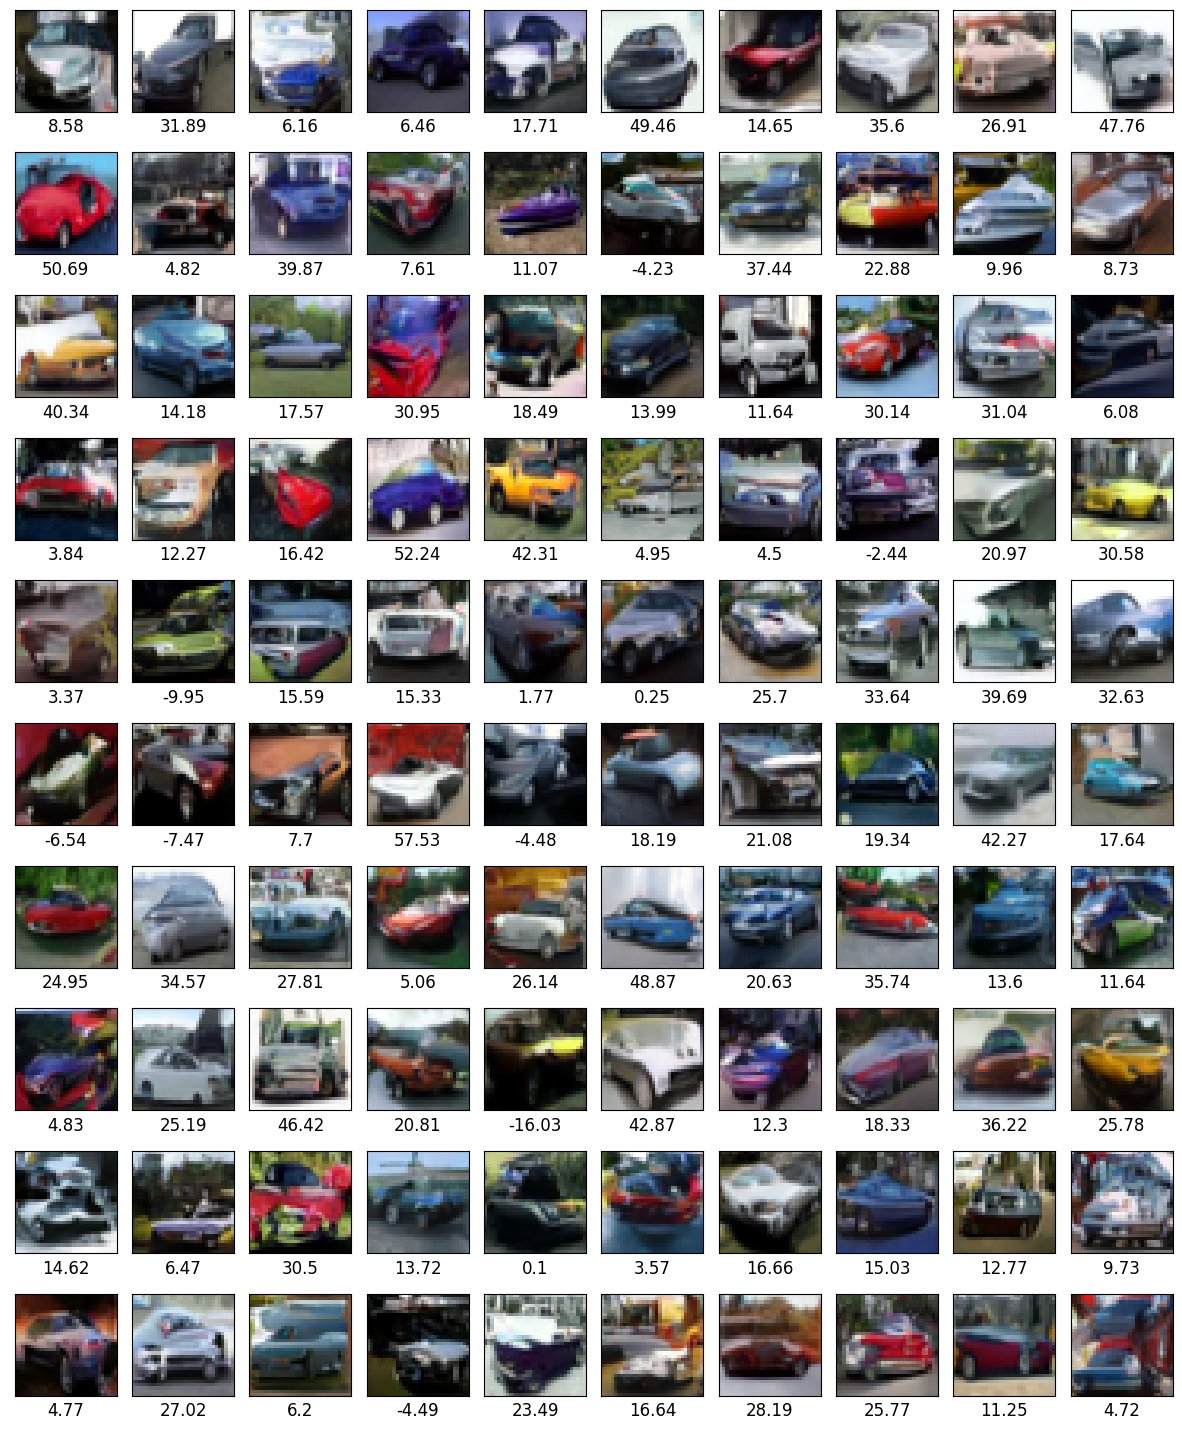

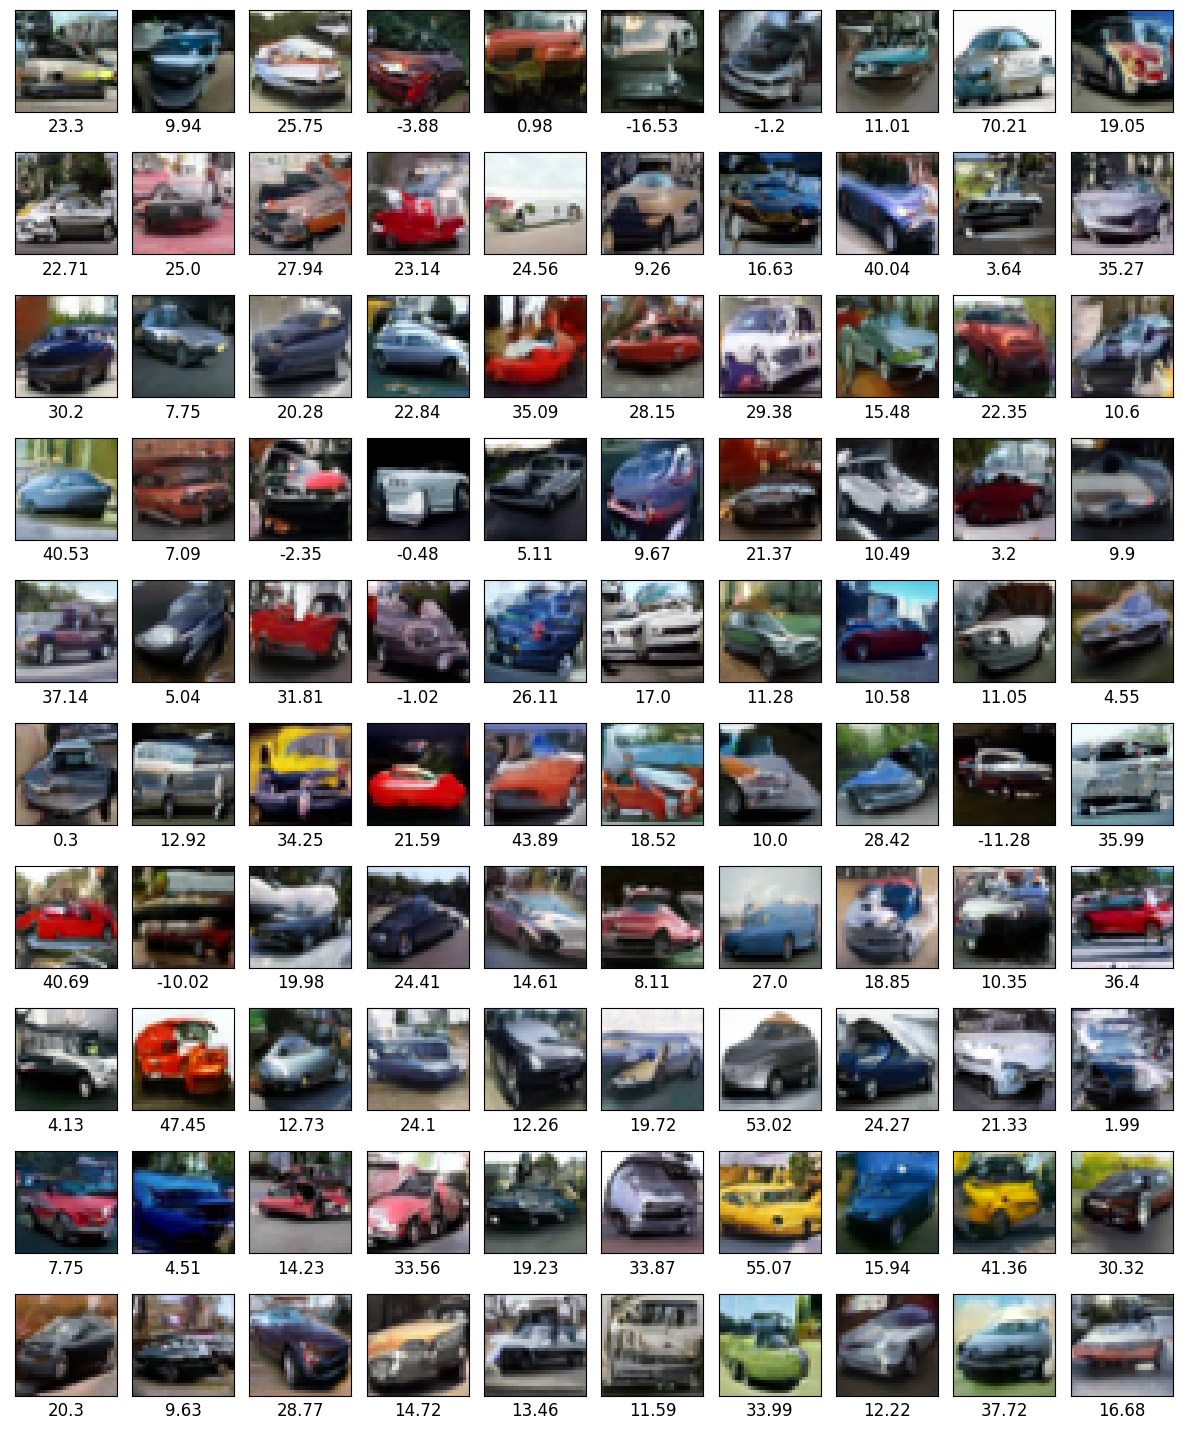

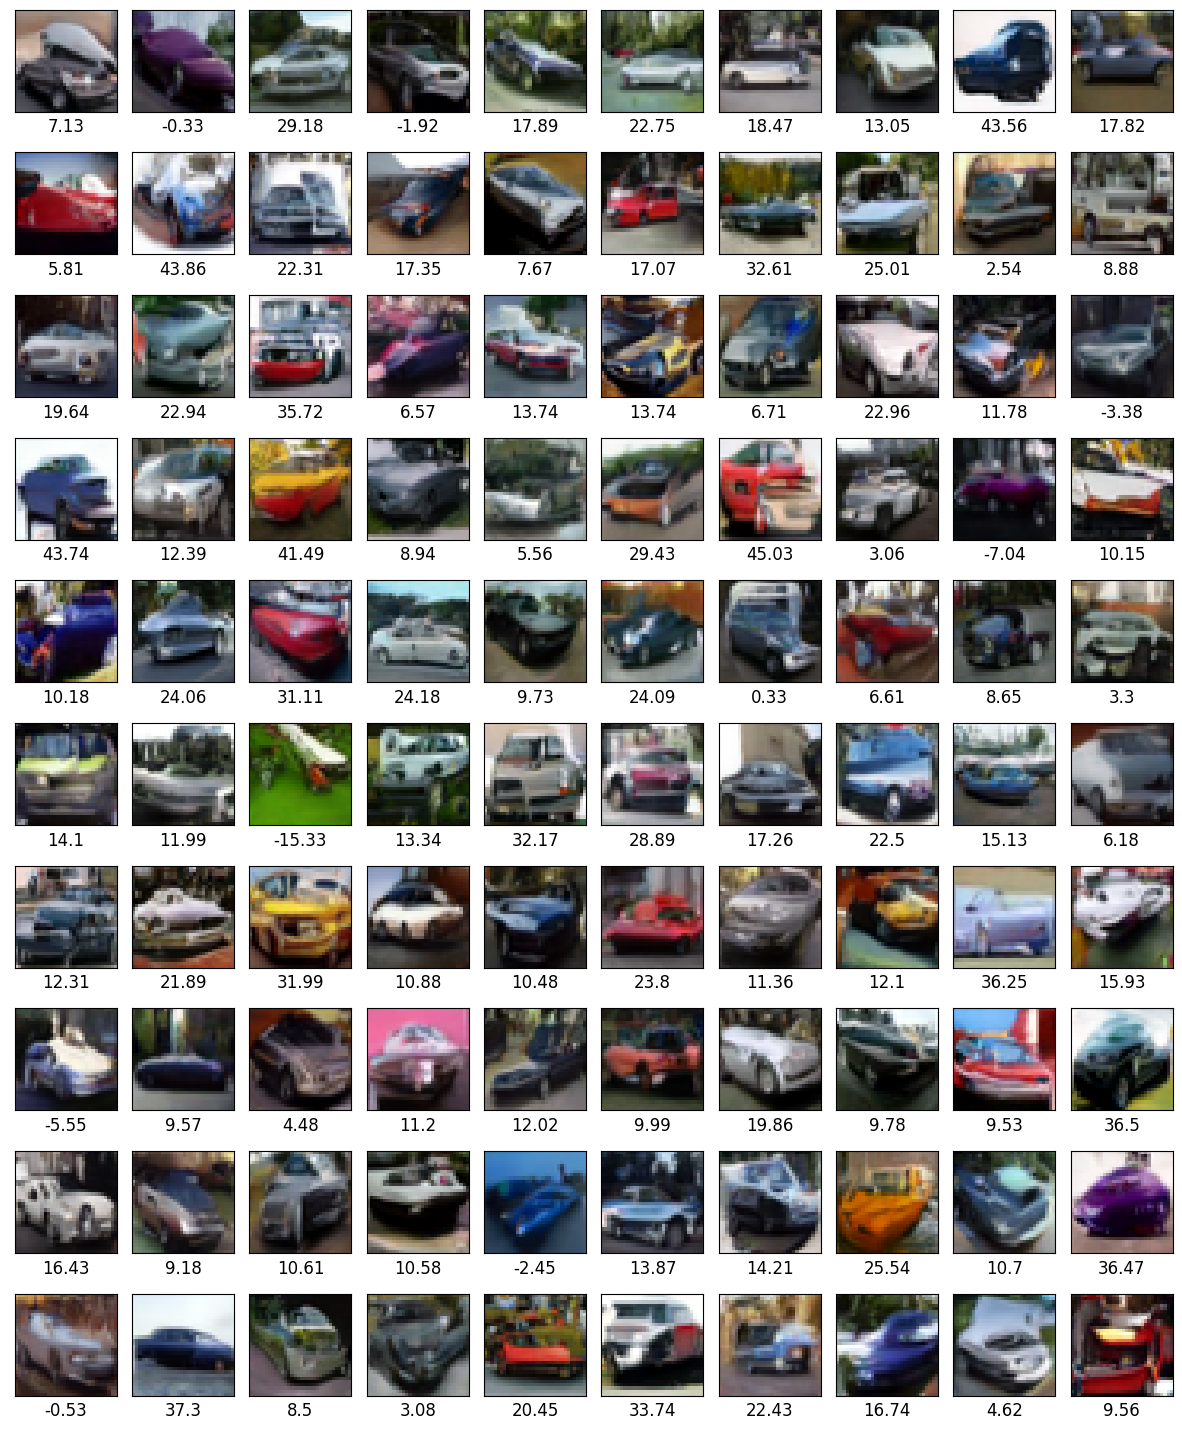

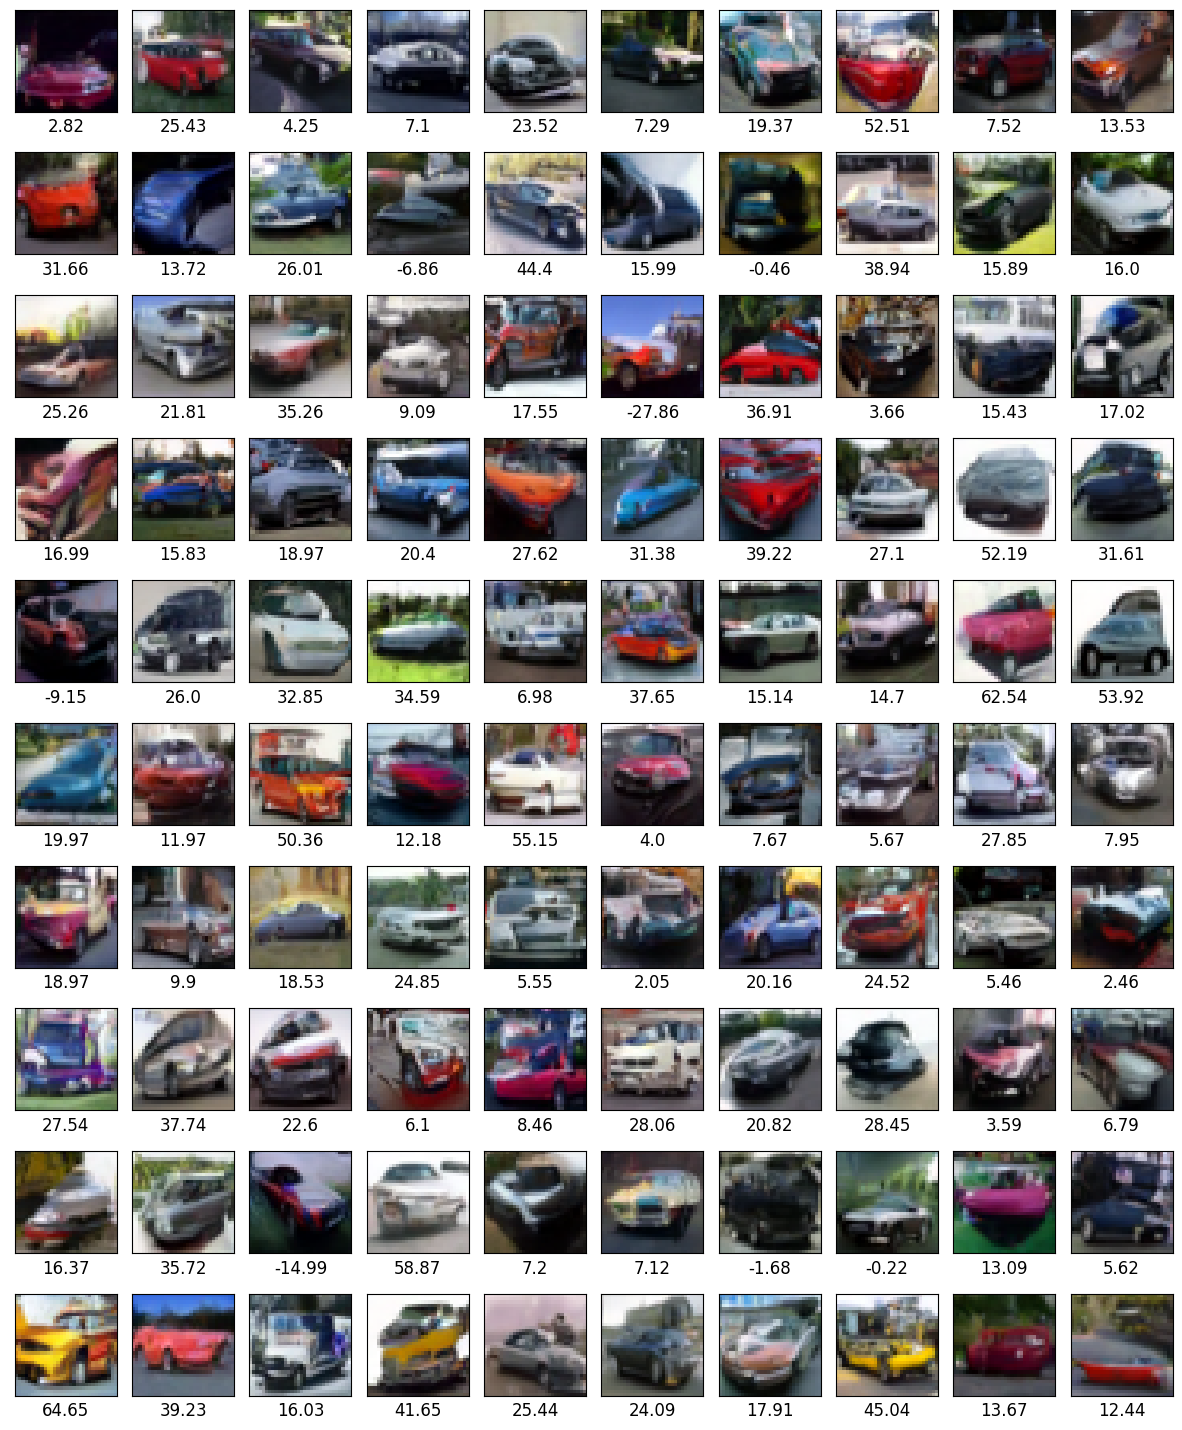

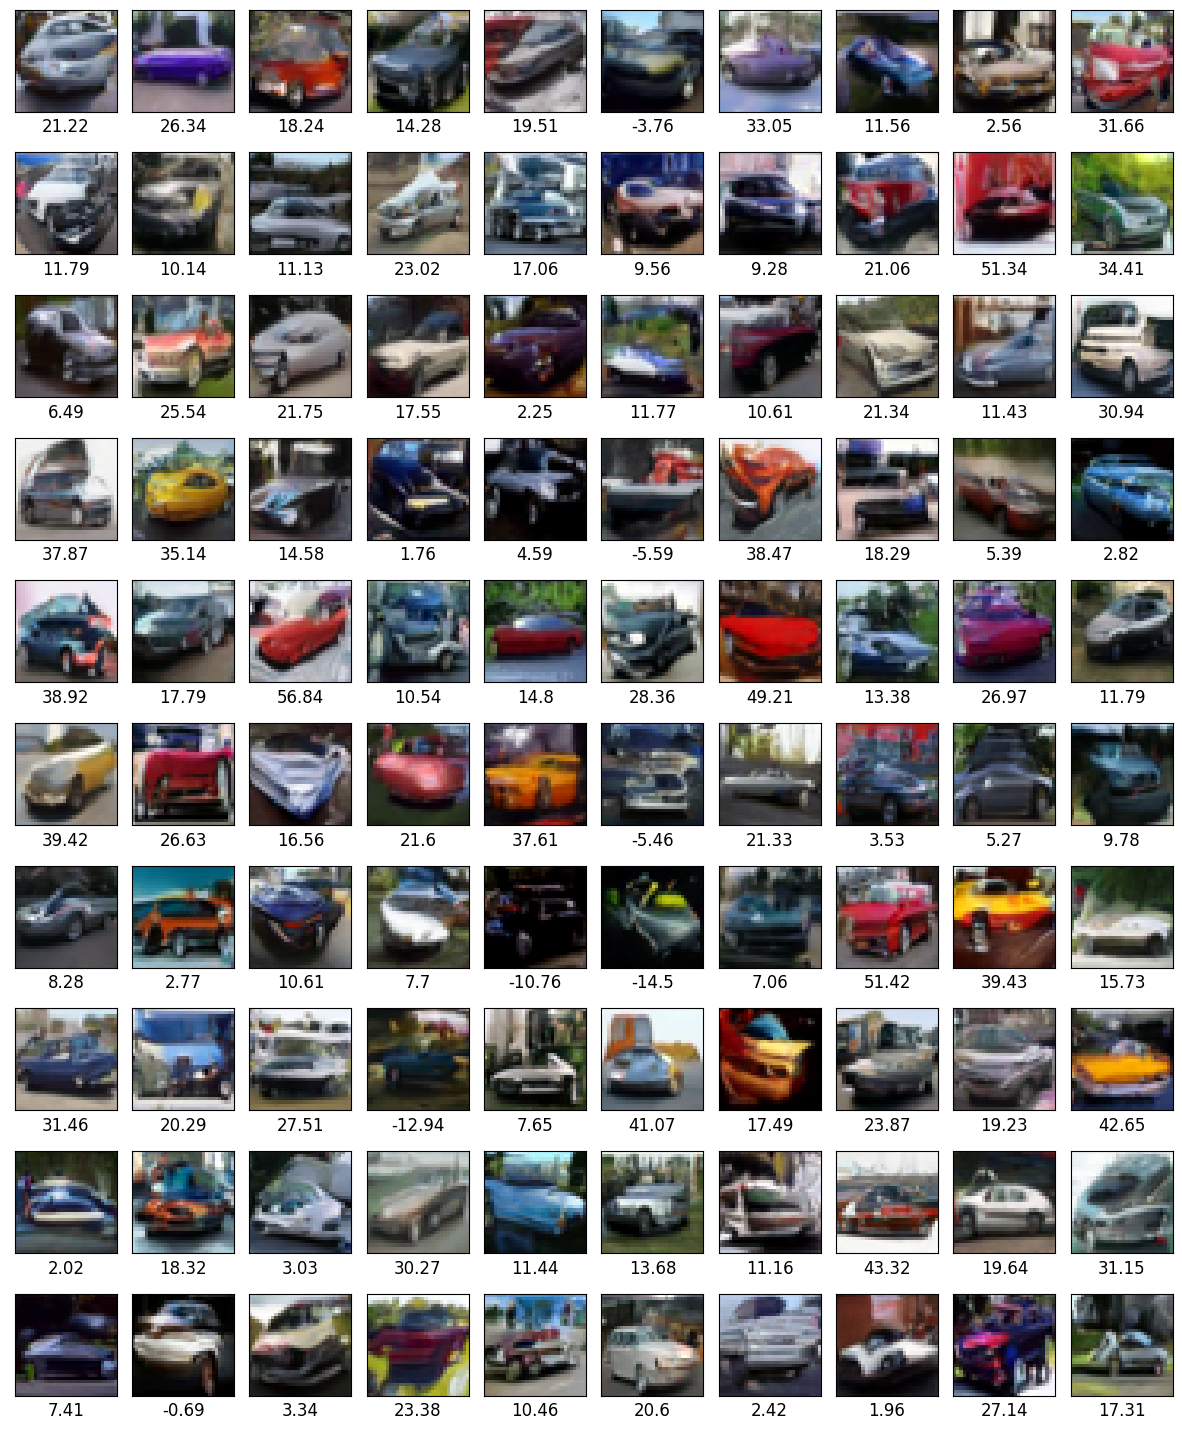

In [55]:
for i in range(5):
    visualize_100_images_with_est(misgenerated_images_batches[i].cpu(), est_array_batches[i])

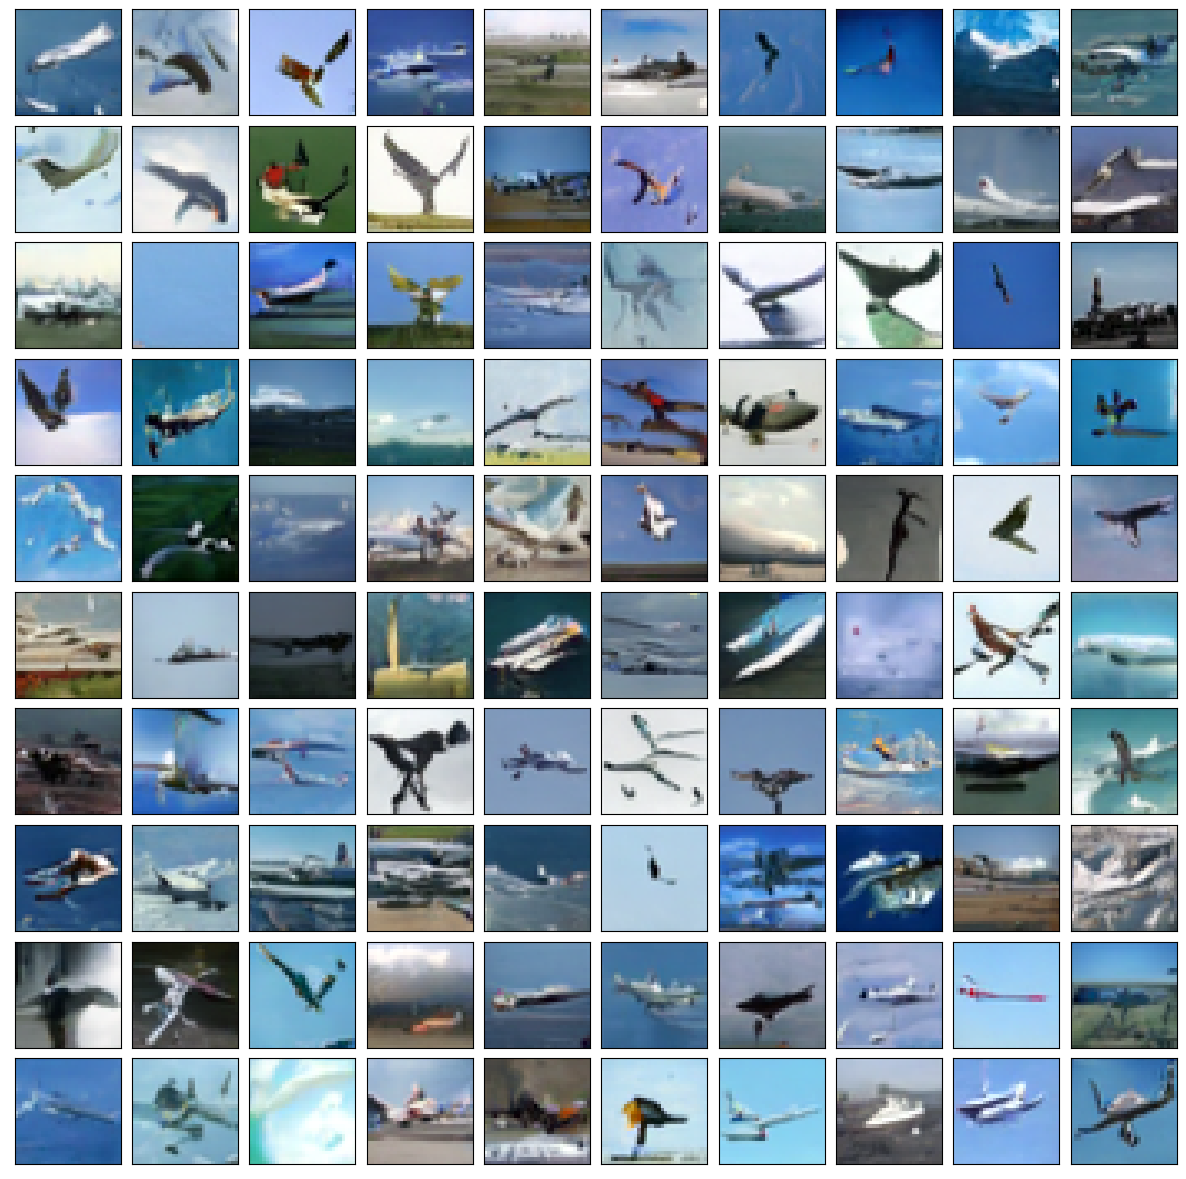

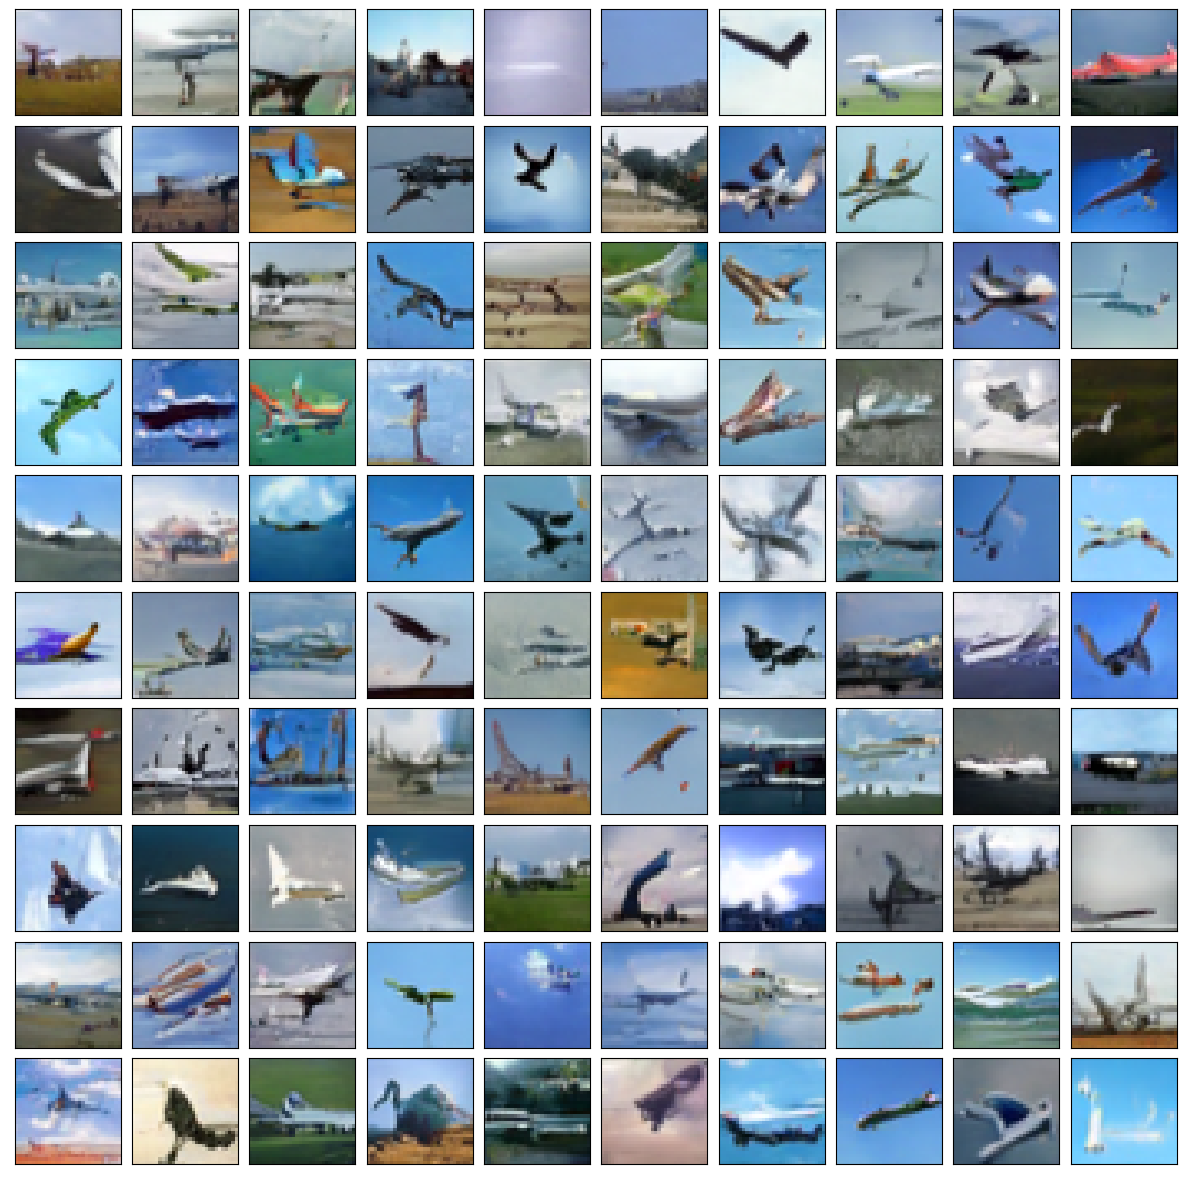

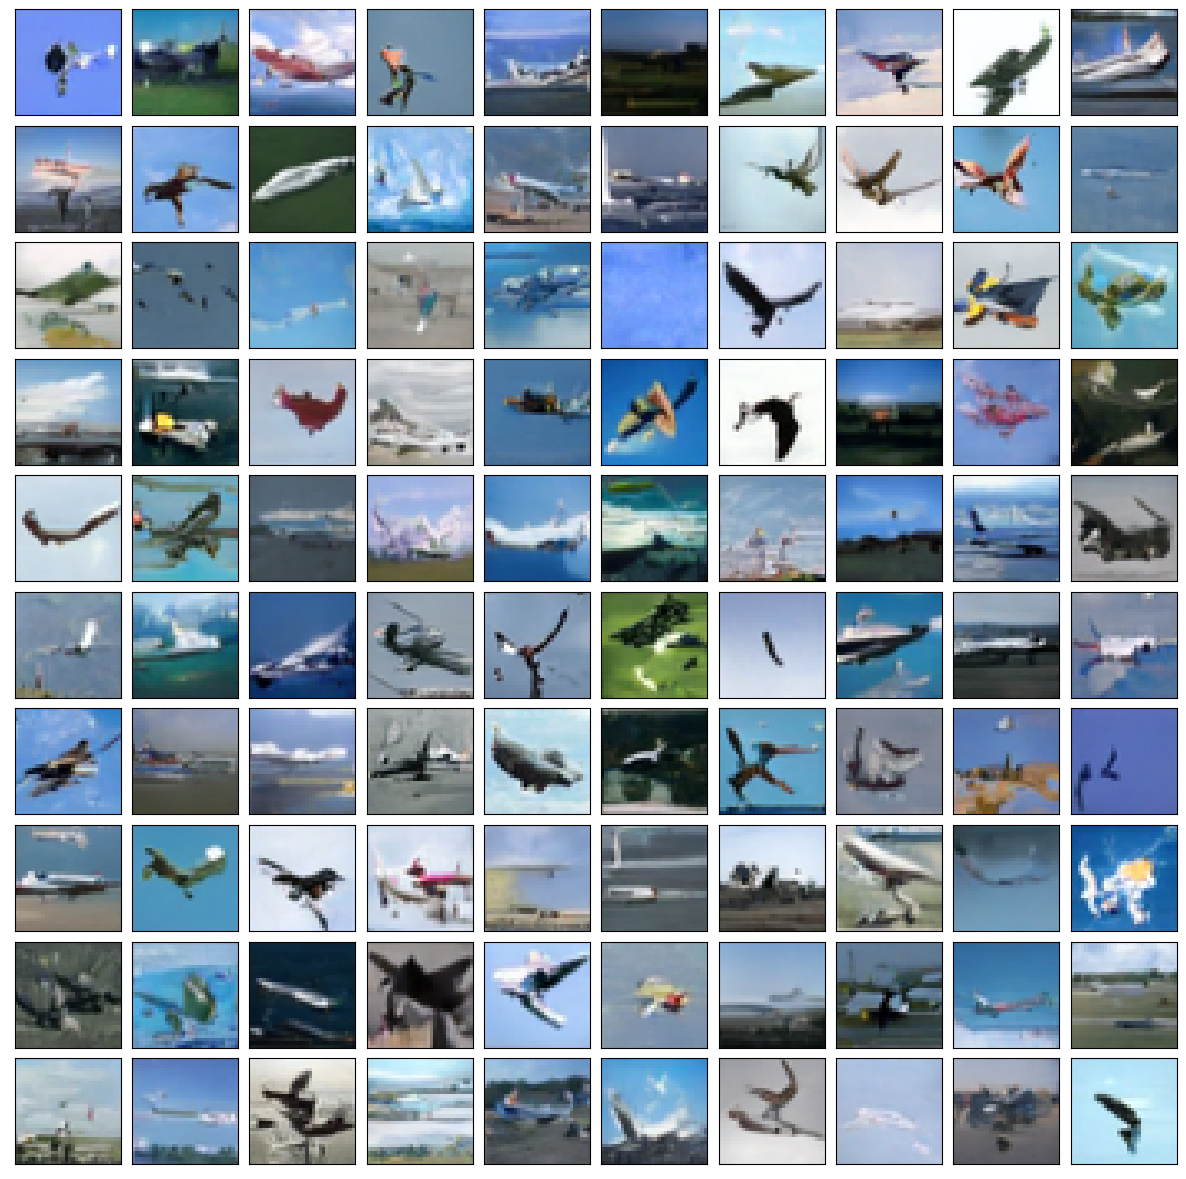

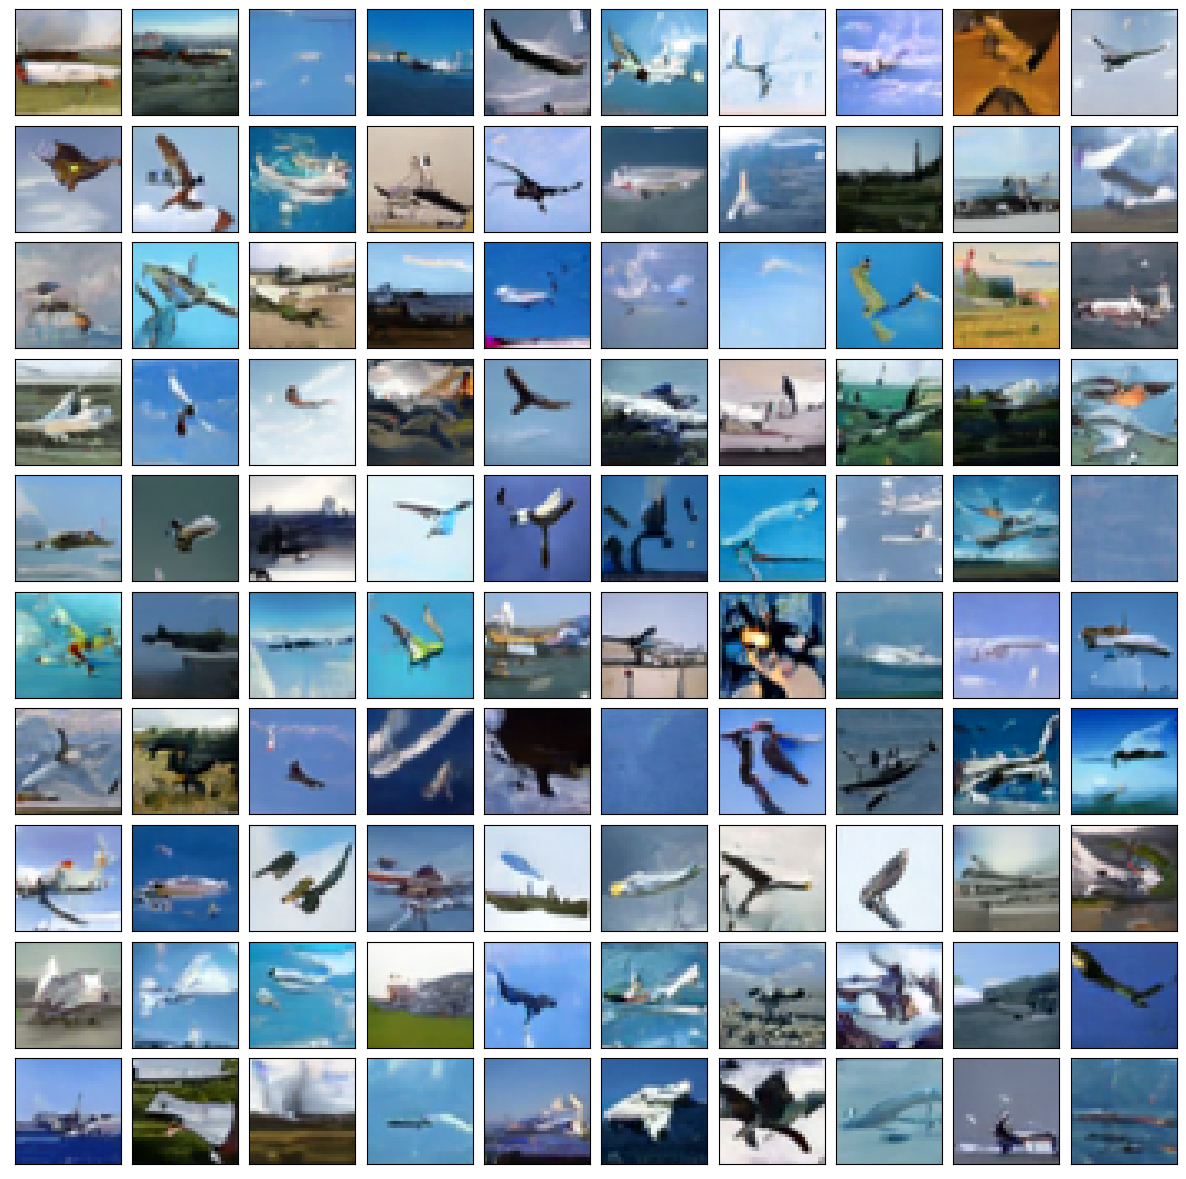

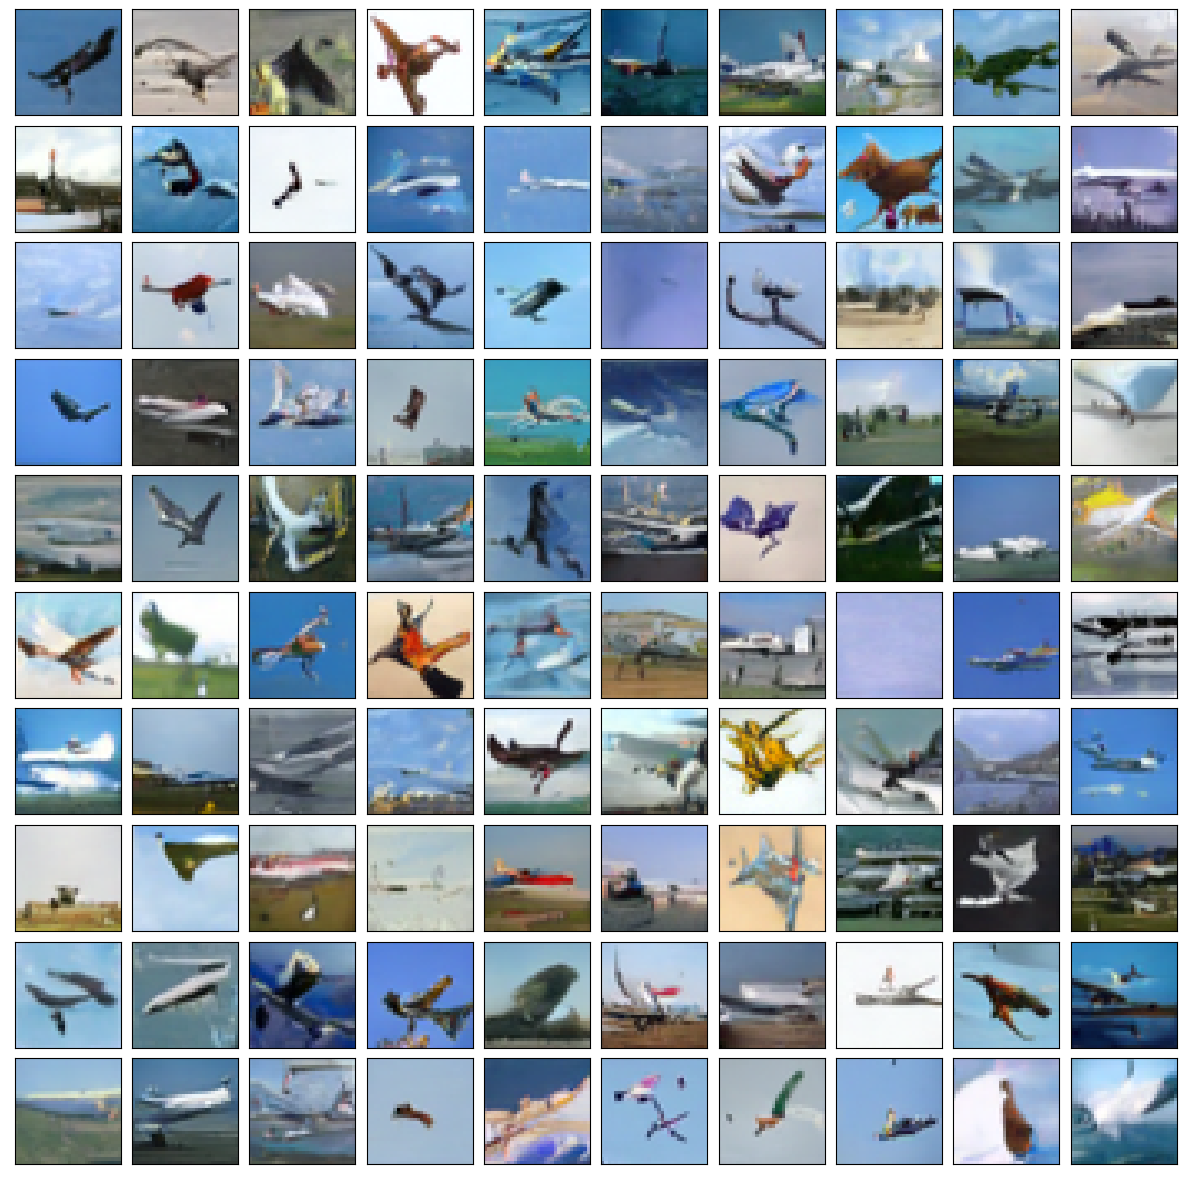

In [4]:
# visualize 500 misgenerated images

for i in range(5):
    visualize_100_images(misgenerated_images_batches[i].cpu())

In [69]:
Img = misgenerated_images_batches[0][2]

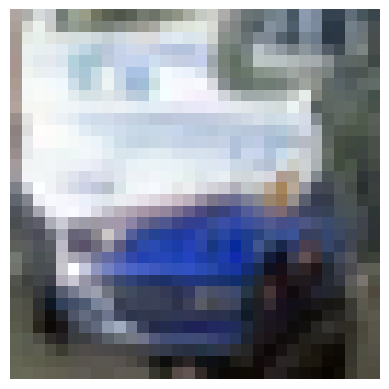

In [70]:
visualize_single_image(Img.cpu())

In [75]:
# calculate pointwise mutual information with correct label

est500_values = []
est4000_values = []

for _ in range(100):
    _, est500 = map(lambda x: x.cpu().numpy(), get_pointwise_mutual_info_2(img=Img, label=label, w=1.0))
    _, est4000 = map(lambda x: x.cpu().numpy(), get_pointwise_mutual_info_3(img=Img, label=label, w=1.0))
    est500_values.append(est500)
    est4000_values.append(est4000)
    print("500 steps :", est500)
    print("4000 steps :", est4000)

est500_array = np.array(est500_values)
est4000_array = np.array(est4000_values)

# print("Mean:", np.mean(est_array))
# print("SD:", np.sqrt(np.var(est_array)))

500 steps : 5.304910683035117
4000 steps : 4.36542334874054
500 steps : 4.25900584718668
4000 steps : 6.657983051438988
500 steps : 5.621256043930075
4000 steps : 9.2460401715702
500 steps : 2.870548444900928
4000 steps : 12.213606749245885
500 steps : 4.051538424242229
4000 steps : 9.91894094274281
500 steps : -1.1835563186554463
4000 steps : 6.743030519460524
500 steps : 0.0182064231062391
4000 steps : 8.983057167141345
500 steps : 0.7988962241453308
4000 steps : 4.643428222942191
500 steps : 7.753817947755467
4000 steps : -2.880315526604576
500 steps : 6.407116077265121
4000 steps : 12.952604205156852
500 steps : 9.488798460596549
4000 steps : 12.40011211867865
500 steps : 5.055055968818884
4000 steps : 5.49650142222799
500 steps : 8.177260160596436
4000 steps : 5.20266510332306
500 steps : 8.648777101428841
4000 steps : 8.328397378797955
500 steps : -0.01879949809020509
4000 steps : 15.266810082344293
500 steps : 1.9943445698897486
4000 steps : 2.6352506058216223
500 steps : 1.3822

In [9]:
print(est_array)

[49.71356914 52.63151261 50.7112848  59.17193831 56.45959035 54.54587228
 60.28298529 52.52782354 58.20350163 48.4565885  60.49974857 55.35354432
 51.32526761 62.39073687 54.31696192 55.30038393 57.51915379 50.62136824
 57.97135554 56.12521644 54.14770354 58.18053245 56.48466006 54.64424761
 62.93721664 52.43341441 59.19477336 55.39478734 57.01269819 55.37640378
 56.40051072 51.87537746 56.79184706 62.66810471 59.69096055 59.05093682
 54.42528592 59.43541713 56.35313466 55.68898553 52.82560635 52.98619514
 55.51062389 59.3345949  56.37491217 48.94073186 60.52399098 55.57454064
 62.82349037 55.57858591 60.99588549 56.20512819 49.87286931 58.94535819
 54.94192696 52.50976061 62.49582509 53.42341196 49.43430474 55.72302195
 62.22228121 54.11224411 58.23931918 57.60551559 51.81577747 58.58476219
 65.45940001 56.14054467 61.75257288 59.28231559 55.87924389 56.23833525
 54.81667182 52.28275414 50.88389452 60.75714158 61.28663571 47.51559743
 59.95260252 56.93600649 51.06899805 58.05307332 50

In [6]:
# generate image from DDPM + classifier free guidance

device = torch.device(modelConfig["device"])
# load model and evaluate
with torch.no_grad():
    model = UNet(T=modelConfig["T"], num_labels=10, ch=modelConfig["channel"], ch_mult=modelConfig["channel_mult"],
                    num_res_blocks=modelConfig["num_res_blocks"], dropout=modelConfig["dropout"]).to(device)
    ckpt = torch.load(os.path.join(
        modelConfig["save_dir"], modelConfig["test_load_weight"]), map_location=device)
    model.load_state_dict(ckpt)
    print("model load weight done.")
    model.eval()
    sampler = GaussianDiffusionSampler(
        model, modelConfig["beta_1"], modelConfig["beta_T"], modelConfig["T"], w=modelConfig["w"]).to(device)
    # Sampled from standard normal distribution
    noisyImage = torch.randn(
        size=[modelConfig["batch_size"], 3, modelConfig["img_size"], modelConfig["img_size"]], device=device)
    sampledImgs = sampler(noisyImage, torch.tensor([label]*modelConfig["batch_size"]).to(device))

model load weight done.


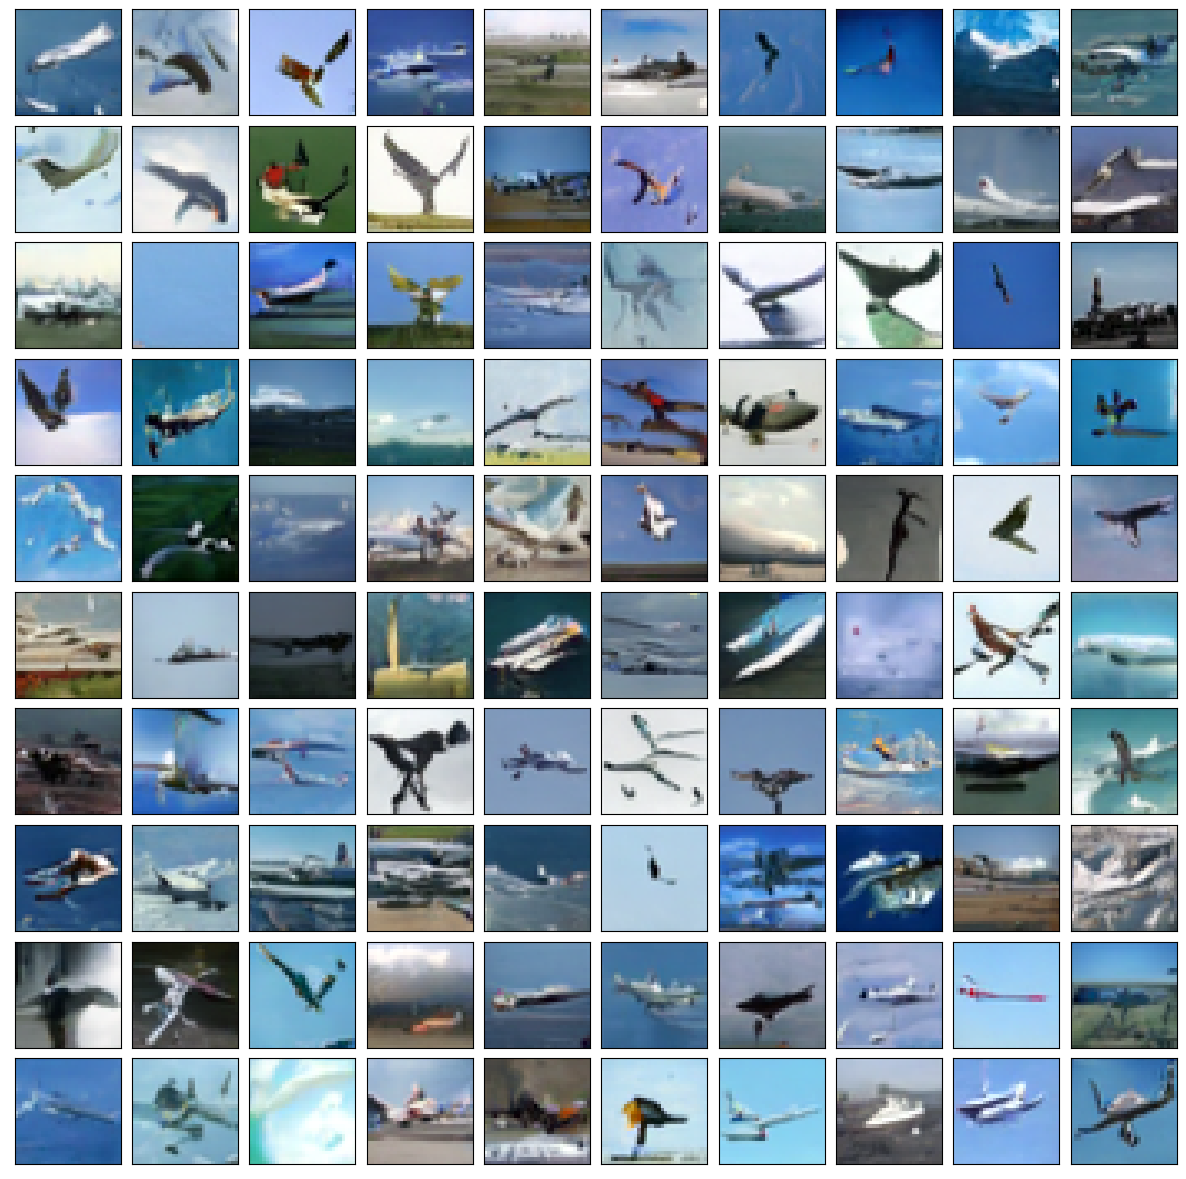

In [14]:
# visualize sampled image

visualize_100_images(sampledImgs.cpu())

In [8]:
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_repvgg_a2", pretrained=True)
model = model.to("cuda:0")
model.eval()

with torch.no_grad():
    output = model(sampledImgs)
    _, predicted = torch.max(output.data, 1)
    predicted_labels = predicted + 1

indices_not_equal = torch.nonzero(predicted_labels != label).squeeze()
predicted_labels_not_equal = predicted_labels[indices_not_equal]

print("Indices of elements not equal to {}: {}".format(label, indices_not_equal.tolist()))
print("Labels that these images are classified to: {}".format(predicted_labels_not_equal.tolist()))

Using cache found in /home/jovyan/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Indices of elements not equal to 3: [3, 7, 11, 21, 22, 24, 25, 29, 30, 34, 35, 39, 44, 46, 47, 48, 53, 59, 60, 63, 64, 67, 68, 70, 82, 85, 86, 87, 91, 93, 94, 96]
Labels that these images are classified to: [4, 5, 4, 7, 4, 4, 5, 7, 4, 4, 1, 4, 4, 7, 4, 7, 1, 4, 5, 4, 8, 7, 7, 4, 6, 6, 4, 7, 1, 5, 1, 7]


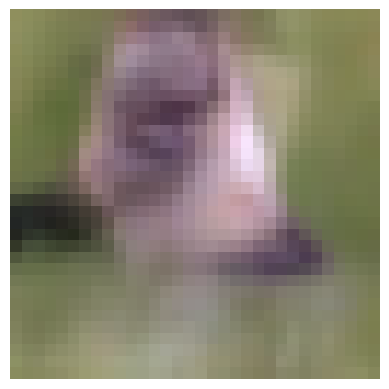

In [10]:
# set index to investigate
idx = indices_not_equal.tolist()[0]
visualize_single_image(sampledImgs[idx].cpu())

In [141]:
# calculate pointwise mutual information with correct label

est1_values = []
est2_values = []

for _ in range(1):
    est1, est2 = map(lambda x: x.cpu().numpy(), get_pointwise_mutual_info_2(img=sampledImgs[idx], label=label, w=1.0))
    est1_values.append(est1)
    est2_values.append(est2)

est1_array = np.array(est1_values)
est2_array = np.array(est2_values)

print("Mean of est1:", np.mean(est1_array))
print("SD of est1:", np.sqrt(np.var(est1_array)))
print("Mean of est2:", np.mean(est2_array))
print("SD of est2:", np.sqrt(np.var(est2_array)))

Mean of est1: -19.296637855757645
SD of est1: 0.0
Mean of est2: -20.35044549078563
SD of est2: 0.0


In [142]:
# Calculate pointwise mutual information with wrong labels

est1_values = {}
est2_values = {}

# Assuming label has a value between 1 and 10
all_labels = set(range(1, 11))  # All possible labels between 1 and 10
other_labels = all_labels - {label}  # Remove the current label from the set

for other_label in other_labels:
    est1_values[other_label] = []
    est2_values[other_label] = []
    
    for _ in range(10):
        est1, est2 = map(lambda x: x.cpu().numpy(), get_pointwise_mutual_info_2(img=sampledImgs[idx], label=other_label, w=1.0))
        est1_values[other_label].append(est1)
        est2_values[other_label].append(est2)

# Calculate mean and variance for each label
for other_label in other_labels:
    est1_array = np.array(est1_values[other_label])
    est2_array = np.array(est2_values[other_label])
    
    print(f"For label {other_label}:")
    print("Mean of est1:", np.mean(est1_array))
    print("Variance of est1:", np.var(est1_array))
    print("Mean of est2:", np.mean(est2_array))
    print("Variance of est2:", np.var(est2_array))
    print("--------")

For label 1:
Mean of est1: -13.371119037292024
Variance of est1: 49.53768344286921
Mean of est2: -11.27235943228376
Variance of est2: 20.094522509265627
--------
For label 2:
Mean of est1: -30.297527429664616
Variance of est1: 52.50396063196432
Mean of est2: -29.265518008339647
Variance of est2: 22.867629530672627
--------
For label 4:
Mean of est1: -7.163096020665185
Variance of est1: 3.2509733083769747
Mean of est2: -6.477359107938715
Variance of est2: 4.675184320611408
--------
For label 5:
Mean of est1: 17.718678302509566
Variance of est1: 10.989125850075501
Mean of est2: 15.81128694504956
Variance of est2: 6.211793039586361
--------
For label 6:
Mean of est1: 26.068750925226773
Variance of est1: 17.395407155499424
Mean of est2: 26.51843895582281
Variance of est2: 20.24061652204355
--------
For label 7:
Mean of est1: -22.77715711300301
Variance of est1: 8.989694942950821
Mean of est2: -21.53348031017849
Variance of est2: 6.681008084816415
--------
For label 8:
Mean of est1: 20.3062